<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Anonyme

// *Version lancée avec Google Colab et enregistrée avec toutes les sorties* //

# Domain-Adversarial Training of Neural Networks




**Note préliminaire** :
Ce notebook a été rédigé sur **Visual Studio Code** et est donc plus agréable à lire sur cette plateforme (couleurs des Markdown etc.), le visuel constitue un élément pédagogique tout de même important.

Cependant, veuillez noter que pour entrainer les réseaux de neurones, il est recommandé d'utiliser cuda (GPU), ou au minimum un CPU puissant (celui de ma machine ne suffit pas par exemple alors que le CPU de Google Colab est ok).

Il est donc conseillé de :
- prendre connaissance du notebook sur VScode ou directement sur le GitHub (anonyme !) suivant : https://github.com/anonymusSDD/DANN_notebook,
- puis de faire tourner les exemples sur Google Colab ([en cliquant ici](https://colab.research.google.com/github/anonymusSDD/DANN_notebook/blob/main/notebook_DANN_empty.ipynb?hl=fr)).

Bonne lecture !

## Contenu du notebook

Ce notebook présente une nouvelle approche d'Adaptation de Domaine en deep learning.

0. [Préparation](#sec0)
1. [Contexte : l'Adaptation de Domaine](#sec1)
2. [Mathématiquement](#sec2)
3. [Shallow DANN (version simple)](#sec3)
4. [Généralisation à des architecture de réseaux “profonds”](#sec4)
5. [Datasets : MNIST & MNIST-M](#sec5)
6. [Test du DANN](#sec6)
7. [Autres résultats](#sec7)
8. [Ouverture à d'autres applications](#sec8)
9. [Conclusion](#sec9)
10. [Références](#sec10)

<div class="alert alert-success">

**A la fin de ce notebook, vous devriez :**  
- avoir compris les enjeux de l'<b>Adaptation de Domaine (DA)</b> ;
- avoir découvert une nouvelle technique de DA appliqué aux réseaux de neurones : le <b>Domain-Adversarial Neural Network (DANN)</b> ;
- savoir décrire l'architecture d'un DANN ;
- connaitre les points forts et applications du DANN.
</div>

# <a id="sec0">0. Préparation</a>

Dans ce notebook, nous utiliserons `torch` et `torchvision`. Merci de se référer au site [PyTorch](https://pytorch.org/get-started/locally/) pour une installation en local (si choix de faire tourner en local). Nous utiliserons aussi les packages `sklearn`, `numpy`, et `matplotlib`.

<div class="alert alert-warning">
  <b>Exercice 1</b> :
  Installer les packages nécessaires et vérifier que cela fonctionne en important tout.
</div>

In [1]:
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import numpy as np
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt

<div class="alert alert-warning">
<b>Exercice 2</b> :
Vérifier le type d'exécution.
</div>

Si exécution dans Google Colab, aller dans *Options de connexion supplémentaires --> Modifier le type d'exécution --> T4 GPU*.

In [3]:
if torch.cuda.is_available():
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print("No GPUs available.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Définitions

<div class="alert alert-info">
    
Avant de commencer, rappelons quelques mots clés en lien direct avec le sujet :

- **Apprentissage profond** (Deep Learning) ;
- **Réseaux de neurones** (Neural Networks - NN) ;
- **Données synthétiques** (Synthetic Data) : données générées artificiellement, souvent à l'aide de techniques algorithmiques, qui peuvent être utilisées comme substitut aux données réelles. Elles sont utiles dans les situations où les données réelles sont limitées, coûteuses à obtenir, ou lorsqu'il y a des préoccupations en matière de confidentialité.
- **Classification d'images** (Image Classification) ;
- **Analyse de sentiments** (Sentiment Analysis) : technique utilisée en traitement du langage naturel pour identifier et classer les opinions ou sentiments exprimés dans un texte, généralement comme positif, négatif ou neutre. Elle est largement utilisée pour analyser les opinions des consommateurs dans les avis en ligne, les médias sociaux, etc.
- **Adaptation de domaine** (Domain Adaptation) : notion clé de ce cours, il s'agit d'une technique en apprentissage automatique où un modèle est formé sur un domaine ou une distribution de données (par exemple, des images prises pendant la journée) et adapté pour fonctionner efficacement sur un domaine différent mais lié (par exemple, des images prises la nuit). Cette méthode est souvent utilisée pour surmonter le problème où les données sur lesquelles le modèle est testé diffèrent de celles sur lesquelles il a été entraîné.
</div>

# <a id="sec1">1. Contexte : l'Adaptation de Domaine</a>

## Domain Adaptation (DA)

![Schéma Domaine Adaptation](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/schema_DA.png?raw=1)

(*source image : cours Philippe Giguère [5]*)

Dans le contexte des réseaux de neurones, posséder suffisamment de données labélisées à entrainer est souvent un problème. Il est toujours possible d'obtenir des ensembles de données suffisamment grands en rajoutant des données qui ressemblent, mais qui souffrent, au moment du test, d'un "décalage" par rapport aux données réelles.

On a aussi cité précédemment le cas parlant d'un modèle entrainé sur des photos prises de jour mais que l'on voudrait utiliser sur des photos prises de nuit. Un autre exemple serait dans le contexte de l’analyse de sentiments sur des critiques écrites : si nous avons en notre possession des données labelisées concernant des critiques de films mais que nous voulons classifier les critiques de livres, comment faire ? (*cf photo ci-dessous*)

Au final, toutes ces situations témoignent de l'enjeu de ce qu’on appelle l'**Adaptation de Domaine** (DA).

![Schéma Domaine Adaptation 2](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/schema_DA_2.png?raw=1)

(*source image: cours Philippe Giguère [5]*)

Autrement dit, l'Adaptation de Domaine intervient lors de l'apprentissage d'un classificateur ou d'un prédicteur en présence d'un décalage entre les distributions d'entraînement (**domaine source**) et de test (**domaine cible**).

Plusieurs cas sont possibles :
- le domaine cible est complètement sans label : **adaptation de domaine non-supervisée**;
- le domaine cible a quelques échantillons labelisés : **adaptation de domaine semi-supervisée**.

Dans ce notebook, nous allons nous concentrer sur le cas le plus complexe et considérer le **domaine cible sans label**.
Nous faisons tout de même la remarque que le cas semi-supervisé fonctionne de manière similaire une fois le principe compris sur le cas le plus difficile. Les échantillons labelisés (si existants) du domaine cible peuvent également servir à affiner le modèle.

## Domain Adaptation et Deep Learning

Ces dernières années, le DA a vu ses performances largement augmenter avec la révolution du deep learning.

Dans ce notebook, nous allons étudier en détail une théorie de DA en deep learning : le **Domain-Adversarial Neural Network (DANN)** qui s'insipre un peu du principe du GAN (Generative Adversarial Nets). Il s'appuie notamment sur la théorie d'adaptation de domaine de Ben-David et al. (2006, 2010) [7, 8] et la combine avec du deep learning au sein d’un **seul processus d’entrainement**.

## Domain-Adversarial Neural Network (DANN)

Nous allons, au cours de ce notebook, expliquer plusieurs fois et avec des approches différentes ce qu'est un DANN.

<div class="alert alert-success">
Le principe du <b>Domain-Adversarial Neural Network (DANN)</b> est basé sur l'apprentissage de caractéristiques qui sont à la fois bonnes pour effectuer une tâche d'apprentissage (comme la classification) et invariantes par rapport au changement de domaine (source vers cible). Cela est particulièrement important dans les scénarios où il y a un écart ou un décalage (shift) entre les données d'entrainement (domaine source) et les données sur lesquelles le modèle sera appliqué (domaine cible). Le DANN vise à minimiser cet écart.
</div>

La particularité du DANN est qu'il permet l'apprentissage des caractéristiques, l'adaptation de domaine et la classification **au sein d'une seule architecture unifiée et utilisant un seul algorithme d’apprentissage** (backpropagation).

Pour cela, nous avons besoin de deux classificateurs.

<div class="alert alert-warning">
<b>Exercice 3</b> : Quels sont, selon vous, les deux classificateurs et quelles sont leurs particularités ?
</div>


<details class="alert alert-danger">
    <summary markdown="span"><b>Voir la solution ? (cliquer ici)</b></summary>

(i) un <b>classificateur/prédicteur de labels</b> utilisé pendant l’entrainement et pendant le test ;

(ii) un <b>classificateur de domaine</b> qui distingue le domaine source du domaine cible pendant l’entrainement.

Il faut, bien entendu, que le prédicteur ait un faible risque de se tromper lorqu'on le test sur les exemples sources.

Rappelons que le but est d'apprendre un modèle qui peut bien se généraliser d'un domaine à l'autre, c'est à dire que le classificateur de domaine ne "sache plus reconnaitre" la source de la cible à la fin den l'entrainement. Nous voulons donc que le <b>classificateur de domaine se trompe</b> ! Cela va se faire par l'intégration d'une couche supplémentaire appelée <b>Gradient Reversal Layer (GRL)</b> et que nous détaillerons plus tard.
</details>

<div class="alert alert-warning">

 **Remarque importante :**

 D’habitude, les paramètres des classificateurs sont optimisés afin de minimiser les erreurs sur l’ensemble de l’apprentissage.

 Ici, les paramètres sont optimisés afin de **minimiser l’erreur du classificateur de labels** mais pour **maximiser l’erreur du classificateur de domaine**. La dernière étape travaille donc de manière antagoniste **«adversarially»** et encourage les caractéristiques invariantes des domaines à émerger au cours de l’optimisation.
</div>

 Tout ce processus d’entrainement est regroupé au sein du **Domain-Adversarial Neural Network (DANN)** dont l'architecture générale est présentée ci-dessous :

![Architecture DANN](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/DANN_architecture.png?raw=1)

La légende explique une première fois le fonctionnement du DANN mais nous allons y revenir, en utilisant d'autres mots, et nous détaillerons pogressivement chaque étape de sa construction.

La première remarque que nous pouvons faire est que nous reconnaissons une architecture classique d'un réseau de neurones avec :
- un **feature extractor** (vert),
- un **label predictor** (bleu),

qui à eux deux forment une architecture feed-forward classique (couches et fonctions loss classiques). Ils sont entrainés en utilisant un algorithme de backpropagation basé sur une descente de gradient stochastique (ou des versions modifiées).

La particularité du DANN est l'ajout du troisième composant : le **domain classifier** (rouge) associé à une couche spéciale appelée le **gradient reversal layer** (GRL). Cette dernière :
- laisse les entrées inchangées lors de l’étape de forward propagation,
- mais inverse le gradient en le multipliant par un scalaire négatif lors de la backpropagation.

Finalement, on voit que toute architecture de réseaux de neurones classique entrainable par backpropagation peut servir de base à un DANN, ce qui le rend très pratique !

# <a id="sec2">2. Mathématiquement </a>

Revenons sur toutes les notions expliquées précédemment mais d'un point de vue mathématique cette fois-ci.

## Domain Adaptation (DA)

On considère une tâche de classification où $X$ est l'expace d'entrée et $Y = \{0,1,\ldots,L-1\}$ l'ensemble des $L$ labels possibles. Nous avons deux distributions :
- la première sur $X \times Y$, appelée *domaine source* $D_S$,
- et le *domaine cible* $D_T$.

Un algorithme d'apprentissage d'*adaption de domaine non-supervisée* est alors donné par un échantillon source labélisé $S$ i.i.d. de $D_S$, et d'un échantillon cible non-labélisé $T$ i.i.d. de $D^X_T$, où $D^X_T$ est la distribution marginale de $D_T$ par rapport à $X$.

$$S = \{(x_i, y_i)\}_{i=1}^n \sim (D_S)^n ; \quad T = \{x_i\}_{i=n+1}^N \sim (D^X_T)^{n'}$$

avec $N = n + n'$ le nombre total d'échantillons. L'objectif de l'algorithme d'apprentissage est de construire un classificateur $$\eta : X \rightarrow Y$$ avec un faible *risque sur la cible*

$$
R_{D_T}(\eta) = Pr_{(x,y)\sim D_T} (\eta(x) \neq y),
$$
tout en ayant aucune information sur les labels de $D_T$.


## Divergence de domaine

L'implémentation d'un DANN demande l'utilisation d'une métrique permettant de mesurer la divergence entre les domaines. La théorie décrite ici applique la **$H$-divergence** présentée par Ben-David et al. (2006, 2010) [7, 8].

![Définition 1](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/def1.png?raw=1)

### Proxy Distance (PAD)

Il est généralement compliqué de calculer exactement cette distance $\hat{d}_{\mathcal{H}}(S, T)$ mais nous pouvons l'approximer relativement facilement. Pour le faire, nous avons besoin d'un nouveau dataset :

(2)
$$    
U = \{ (x_i, 0) \}^n_{i=1} \cup \{ (x_i, 1) \}^N_{i=n+1},
$$

où les exemples de l'échantillon source sont labélisés 0 et les exemples de l'échantillon cible sont labélisés 1.
Le risque du classificateur entrainé sur le nouveau dataset $U$ approxime le "min" de l'Equation (1). Etant donné une erreur générale $\epsilon$ sur la problème de discrimination entre source et cible, la $H$-divergence est ensuite approximé par

(3)
$$
\tilde{d}_{A} = 2(1 - 2\varepsilon).         
$$

Ben-David et al. (2006) appellent cette valeur $\tilde{d}_{A}$ la *Proxy A-distance* (PAD). La A-distance étant définie comme $d_{A}(D_S^X, D_T^X) = 2 \sup_{A \in \mathcal{A}} | \text{Pr}_{D_S^X}(A) - \text{Pr}_{D_T^X}(A) |$ , où $A$ est un sous-ensemble de $X$. Notons qu'en choisissant $A = \{ A_n | n \in \mathcal{H} \}$, avec $A_n$ l'ensemble représenté par la fonction caractéristiques $\eta$, la A-distance et la $H$-divergence de la Définition 1 sont identiques.

Dit de manière simple, la PAD est une métrique estimant la similarité des représentations source et cible. Pour l'obtenir voici les étapes à suivre :
- construire l'ensemble de données U de l'Équation (2) en utilisant à la fois les représentations sources et cibles des échantillons d'apprentissage ;
- diviser aléatoirement U en deux sous-ensembles de taille égale ;
- entraîner des SVM linéaires sur le premier sous-ensemble de U en utilisant une large gamme de valeurs de C (hyper-paramètre du SVM) ;
- calculer l'erreur de tous les classificateurs obtenus sur le second sous-ensemble de U ;
- utiliser l'erreur la plus faible pour calculer la valeur de PAD de l'Équation (3).


Pour plus de précisions sur la théorie du DANN, et plus précisément sur comment diminuer le risque sur le domaine cible et contrôler la $H$-divergence est mathématiquement lié au fait que le domaine source et cibles soient indiscernables, voir l'article [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818) [1] pages 6 et 7, théorème 2.

# <a id="sec3">3. Shallow DANN (version simple)</a>

### Algorithme

La première étape avant de construire notre DANN est de proposer une approche simple pour incorporer un composant de DA dans un réseau de neurones. Le plus simple que nous puissions faire est le réseau suivant :
- une seule couche cachée,
- et fully connected.

C'est ce que nous allons appeler dans la suite un **Shallow DANN** et voici le pseudo-code correspondant.

![ALgorithme 1 - Shallow DANN](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/algo1.png?raw=1)

Ici est fait le choix de passer sous silence la démonstration mathématique liée à cet algorithme. Pour les plus curieux, vous pouvez la retrouver aux pages 7-10 pour le Shallow DANN (et 11-13 pour la version généralisée) de l'article [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818) [1].

Nous revenons tout de même sur les principes fondamentaux.

<div class="alert alert-warning">
Rappelons que l’optimisation implique la minimisation de certains paramètres et la maximisation d’autres.
</div>

Il est proposé d'aborder le problème avec une procédure simple de gradient stochastique, dans laquelle **les mises à jour sont effectuées dans le sens opposé du gradient pour les paramètres minimisant**, et **dans le sens du gradient pour les paramètres maximisants**.
L'algorithme 1 fournit le pseudo-code complet de cette procédure d'apprentissage :
- un couche cachée $G_{f}(.)$ qui mappe toutes les données (source ou cible) ;
- une couche de sortie $G_{y}(.)$ qui classe avec précision les échantillons source ;
- cette dernière couche paralyse en même temps la capacité du régresseur de domaine $G_{d}(.)$ à détecter si chaque exemple provient du domaine source ou cible ;
- le réseau de neurones [feature extractor (vert) + label predictor (bleu)] est paramétré par $W, b, V, c$ ;
- le régresseur de domaine [rouge] est paramétré par $u$ et $e$ ;
- les paramètres du réseau de neurone sont actualisés dans le sens inverse du gradient (signe "-" dans le pseudo-code) ;
- les paramètres du régresseur de domaine sont actualisés dans le sens du gradient (signe "+" dans le pseudo-code).


<div class="alert alert-warning">
<b>Exercice 4</b> : Maintenant que tu comprends un peu mieux le fonctionnement du DANN, peux-tu expliquer avec tes propres mots l'origine de son nom ?
</div>


<details class="alert alert-danger">
    <summary markdown="span"><b>Voir la solution ? (cliquer ici)</b></summary>

Lors de l'entraînement, le réseau de neurones et le régresseur se font concurrence, de manière contradictoire.
C'est l'explication au terme <b>"Adversarial"</b> dans Domain-Adversarial Neural Networks (DANN).
</details>

### Exemple : problème des *inter-twinning moons*

Avec cette version simplifiée du DANN (que nous n'implémenterons pas), il est possible fournir des résultats déjà très bons. Plusieurs résultats intéressants sont disponibles dans l'article [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818) [1] aux pages 13-19.

Pour illustrer ce cours, il a été choisi de présenter les résultats d'un seul problème : le problème 2D des *inter-twinning moons* composé de deux ensembles de points qui forment deux formes en demi-cercle ("lunes"), qui se chevauchent partiellement (d'où le terme "inter-twinning"). Chaque lune représente une classe différente.

![Toy problem - shallow DANN](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/toy_problem.png?raw=1)

Conditions de l'expérience :
1. Un **échantillon source S** comprenant 150 exemples issus de la lune inférieure (label 0) et 150 exemples issus de la lune supérieure (label 1) ;
2. Un **échantillon cible T** de 300 exemples non labelisés obtenu par la procédure suivante :
    - génération d'un échantillon S' de la même manière que S a été généré ;
    - rotation de chaque exemple de 35° ;
3. Un **DANN** VS un **réseau de neurones classique (NN)**, avec la même architecture de base (une couche cachée de 15 neurones) ;
4. NN entraîné exactement comme le DANN : mise à jour du régresseur de domaine grâce à T (avec un hyper-paramètre λ = 6 ; même valeur que pour DANN), mais la backpropagation adversariale est désactivée dans la couche cachée (cf algorithme 1 en omettant les lignes 22-31).

Analysons les résultats colonne par colonne :

- **Label classification** : on voit que le NN classe correctement les deux classes de l'échantillon source S, mais n'est pas entièrement adapté à l'échantillon cible T. Avec l'application du DANN, la frontière de décision est légèrement déplacée ce qui fait que les points du domaine cible tombent du bon côté et donc ce qui augmente le performance du modèle. L'exemple du DANN classe parfaitement les exemples des échantillons source et cible.
- **Representation PCA** : les graphiques sont obtenus en appliquant une analyse en composantes principales (PCA) sur l'ensemble de toutes les données source et cible. Dans la représentation PCA-DANN, les points cibles sont homogènement répartis parmi les points sources. Dans la représentation PCA-NN, les points cibles appartiennent clairement à des clusters ne contenant aucun point source. Labéliser les points cibles semble être une tâche clairement plus facile pour le DANN. Notons aussi les quatre lettres A, B, C et D, qui correspondent aux quatre extrêmes de l'espace original. Nous observons que les points A et B (de même pour C et D) sont très proches l'un de l'autre dans la représentation PCA-NN, alors qu'ils appartiennent clairement à des classes différentes à l'origine. Au contraire, la représentation PCA-DANN respecte bien cette séparation et est une nouvelle fois mieux adaptée au problème d'adaptation.
- **Domain classification** : ici, on visualise la frontière de décision sur le problème de classification de domaine. L'interprétation est légèrement plus subtile. Le NN arrive plus ou moins à séparer les éléments venant du domaine source de ceux du domaine cible (frontière grise), certes de manière très imparfaite, mais on devine la tendance à suivre la rotation de la courbe. Au contraine, le DANN échoue complètement ce qui témoigne de sa capacité à généraliser les données en rendant indiscernable le domaine source du domaine cible. Le DANN a donc le comportement attendu.
- **Hidden neurons** : le même constat qu'au-dessus peut s'appliquer. Alors que les 15 lignes du NN sont globalement capables de capturer l'angle de rotation du problème de classification de domaine en se regroupant en deux motifs prédominants (deux lignes parallèles traversant le cadre d'en bas à gauche jusqu'en haut à droite), elles disparaissent complètement dans le cas du DANN.

**Conclusion** : le shallow DANN fonctionne très bien sur des exemples simples !

Remarque : le choix des hyper-paramètres (paramètre d'adaptation $\lambda$, taux d'apprentissage $\mu$, taille couche cachée ... ) se fait par la méthode *reverse-cross validation* proposée par Zhong et al. (2010) [11]. Pour plus d'informations, cf page 16 de l'article [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818) [1].

# <a id="sec4">4. Généralisation à des architecture de réseaux “profonds”</a>

# Architectures arbitraires

Nous allons maintenant nous appuyer sur la section précédent pour généraliser le DANN à des architectures arbitraires, plus appropriées pour de nombreuses applications.

 Rappelons l'architecture générale du DANN :

 ![Architecture DANN](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/DANN_architecture_red.png?raw=1)

Dans la version générale, nous introduison un couche spéciale appelée **gradient reversal layer (GRL)** entre le feature extracteur (vert) et le regresseur de domaine (rouge) :
- la GRL ne nécessite aucun paramètre ;
- pendant la **forward propagation**, la GRL agit de manière totalement **transparente** (= transformation identité).
- pendant la **backpropagation**, la GRL prend le gradient du niveau actuel et **change son signe** en multipliant tout simplement par le scalaire -1, avant de passer à la couche précédente et de remonter tout le réseau.

On revient une fois nouvelle sur le terme "adversarial". En effet, l'entraînement du DANN dualise deux objectifs :
- **Apprentissage de la tâche principale** : le feature extracteur (vert) et le prédicteur/classificateur de labels (bleu) sont entraînés ensemble sur les données du domaine source ;
- **Adversarial Training** : le feature extracteur (vert) est également utilisé pour alimenter le regresseur de domaine (rouge). L'objectif est d'empêcher le regresseur de domaine de distinguer correctement les échantillons provenant du domaine source de ceux du domaine cible. Cela est réalisé en utilisant la "Gradient Reversal Layer" (GRL) qui encourage le feature extracteur (vert) à apprendre des caractéristiques qui sont utiles pour la tâche principale mais qui ne permettent pas la discrimination de domaine.

*Remarque* : après l’apprentissage, le réseau peut bien sûr être utilisé pour prédire des labels pour des échantillons provenant du domaine cible (qui n’ont pas de labels) mais aussi provenant du domaine source (bonne précision normalement).

## Implémentation DANN

Nous allons suivre l'architecture et la méthode détaillées dans l'article [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818) [1].

Le code est inspiré de [NaJaeMin93](https://github.com/NaJaeMin92/pytorch-DANN/blob/master) [3] et adapté pour le besoin de ce cours.

 ![Architecture DANN appliquée à MNIST](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/MNIST_NN_architecture.png?raw=1)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import os

### 1. Encodeur - feature extracteur (vert)

Le **feature extractor ou encodeur** est la partie du réseau qui apprend à extraire des caractéristiques (features) pertinentes à partir des données d'entrée (source et cible). Ces caractéristiques sont utilisées à la fois pour la tâche de classification principale et pour la tâche de discrimination de domaine.

In [5]:
class Extractor(nn.Module):
    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.extractor(x)
        x = x.view(-1, 3 * 28 * 28)
        return x

### 2. Classificateur - prédicteur de labels (bleu)

Le **classificateur ou prédicteur de labels** forme avec l'extracteur un réseau de neurones classique qui utilise les caractéristiques extraites pour effectuer la tâche principale (comme la classification ou la régression) sur le domaine source.

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3 * 28 * 28, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10),
            # pas besoin du softmax à la fin car déjà inclus dans la loss nn.CrossEntropyLoss
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

### 3. Discriminateur - régresseur de domaine (rouge)

Le **discriminateur ou régresseur de domaine** est un autre réseau de neurones qui tente de déterminer si les caractéristiques extraites proviennent du domaine source ou cible.
Une architecture simple (x->100->2) est utilisée afin d'accélérer les tests.

In [7]:
from torch.autograd import Function

# Fonction pour inverser le gradient
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=3 * 28 * 28, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2),
            # pas besoin de sigmoid car déjà inclus dans la loss nn.CrossEntropyLoss
        )

    def forward(self, input_feature, alpha):
        reversed_input = ReverseLayerF.apply(input_feature, alpha)
        x = self.discriminator(reversed_input)
        return x

# <a id="sec5">5. Datasets : MNIST & MNIST-M</a>

Si nous voulons construire notre propre DANN, nous avons besoin d'un jeu de données source et d'un jeu de données cible adaptés au contexte d'étude.

Dans ce notebook, il a été fait le choix de manipuler le célèbre **dataset MNIST** (LeCun et al., 1998) [10]. Il sera notre **dataset source**. Pour rendre ce cours plus intéractif, nous allons construire nous même notre dataset cible : **MNIST-M**.

<div class="alert alert-info">
Le <b>dataset MNIST-M</b> est une variante du dataset MNIST, largement utilisé dans le domaine de l'apprentissage automatique, de la reconnaissance de caractères manuscrits et bien entendu en adaptation de domaine. Alors que le dataset MNIST original contient des images en niveaux de gris de chiffres écrits à la main (de 0 à 9), MNIST-M introduit une complexité supplémentaire : les chiffres du dataset MNIST original sont fusionnés avec des patches colorés et aléatoires provenant de photos. Cela crée un effet de bruit de fond coloré, rendant la reconnaissance des chiffres plus difficile.
</div>

<div class="alert alert-warning">

  Pour résumer, nous allons donc avoir :

- un domaine source : dataset MNIST,
- un domaine cible : dataset MNIST-M.

</div>

In [9]:
# Quelques fonctions utiles pour la suite
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.utils.data as data
import torchvision.datasets as datasets
from torchvision import transforms
from PIL import Image
import random

### Paramètres

In [10]:
# Définition des paramètres
batch_size = 32 # valeur adaptée à notre exemple (garder cette valeur pour la suite)
epochs = 3 # 3 époques pour commencer, on pourra augmenter ce nombre si besoin, attention au temps de calcul
num_workers = 4 # nombre de workers pour le chargement des données

### MNIST

In [11]:
# Chargement du dataset MNIST avec PyTorch
transform = transforms.Compose([transforms.ToTensor(), # Transformation des images en tensors PyTorch
                                transforms.Normalize((0.1307,), (0.3081,)) # Valeurs de normalisation connues pour le dataset MNIST
                                ])

mnist_train_dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
mnist_valid_dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
mnist_test_dataset = datasets.MNIST(root='./data/MNIST', train=False, transform=transform)

indices = list(range(len(mnist_train_dataset)))
validation_size = 5000
train_idx, valid_idx = indices[validation_size:], indices[:validation_size]
train_sampler = SubsetRandomSampler(train_idx)

mnist_train_loader = DataLoader(
    mnist_train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

mnist_test_loader = DataLoader(
    mnist_test_dataset,
    batch_size=batch_size,
    num_workers=num_workers
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


------ Exemples d'images du dataset MNIST ------


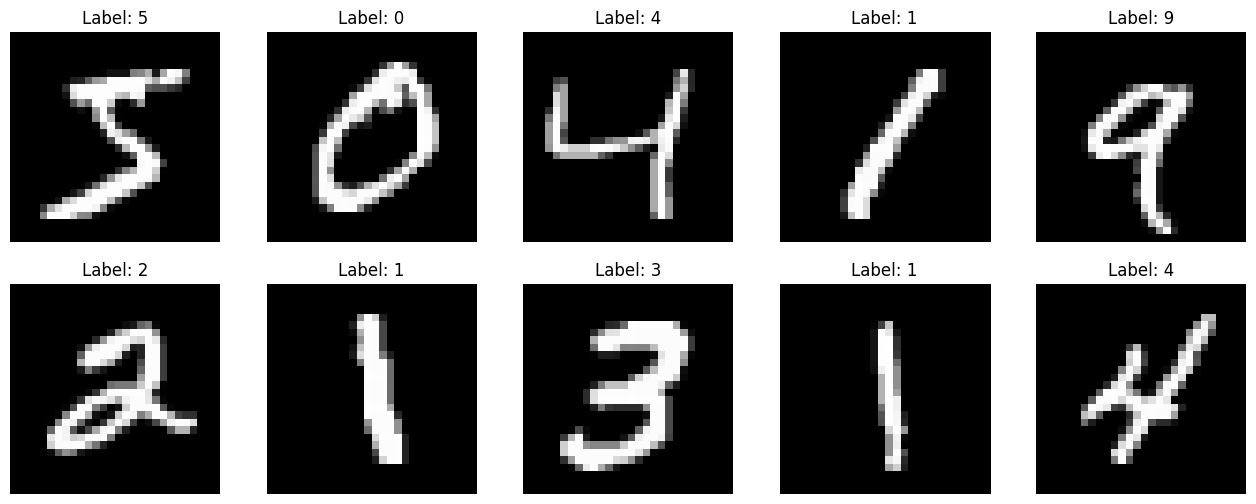

In [12]:
#Visualisation de quelques images issues du dataset MNIST avec leurs labels, en noir et blanc

print("------ Exemples d'images du dataset MNIST ------")
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image_tensor, label = mnist_train_loader.dataset[i]
    image_numpy = image_tensor.permute(1, 2, 0).numpy()  # Convertit le tensor en format numpy et réarrange les dimensions
    plt.imshow(image_numpy, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.show()

### MNIST-M

Il n'y a pas de dataset MNIST-M disponible dans les librairies PyTorch.
Au lieu d'importer ces données d'une autre source, nous allons plutôt créer notre propre dataset personnalisé.
Pour cela, il va vous falloir télécharger une photo. Il vous est proposé d'utiliser celle qui a été choisie pour cet exemple *(./img/background.jpg ou ./img/background2.jpg)* mais il vous est également possible de charger une photo de votre choix dans la cellule ci-dessous. Pensez à choisir une image avec de belles couleurs vives pour de plus beaux résultats.

Voici un lien où vous pouvez trouver des photos libres de droit : [site web photos](https://pixabay.com/fr/).

In [13]:
# # Chargement de l'image qui sera utilisée en fond d'écran, au choix
# background_img = Image.open('./img/background.jpg')
# # background_img = Image.open('./img/background2.jpg')

# # Vérifier que les dimensions de l'image sont plus grandes que 28x28 pixels
# print(background_img.size)

# # Afficher l'image téléchargée
# plt.imshow(background_img)

OU si utilisation de **Google Colab** (enlever les commentaires) :

fatal: destination path 'DANN_notebook' already exists and is not an empty directory.
(1280, 853)


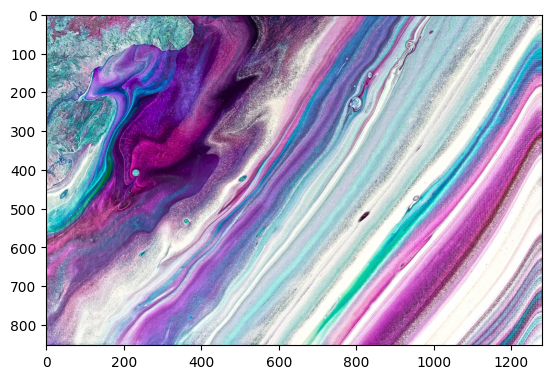

In [14]:
# Téléchargement du dossier DANN depuis le dépôt GitHub
!git clone https://github.com/anonymusSDD/DANN_notebook.git

# Chargement de l'image qui sera utilisée en fond d'écran, au choix
background_img = Image.open('./DANN_notebook/img/background.jpg')
# background_img = Image.open('./DANN_notebook/img/background2.jpg')

# Vérifier que les dimensions de l'image sont plus grandes que 28x28 pixels
print(background_img.size)

# Afficher l'image téléchargée
plt.imshow(background_img)

In [15]:
# Code pour importer une nouvelle fois le dataset MNIST, mais cette fois-ci en RGB

# Transformation pour convertir les images MNIST en RGB
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

# Transformation pour convertir les images en tensors PyTorch, en RGB, mais pas de normalisation
transform = transforms.Compose([
    transforms.Lambda(to_rgb),
    transforms.ToTensor()
])

# Téléchargement de dataset MNIST en RGB
mnist_dataset_train = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
mnist_dataset_test = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=transform)

# DataLoader
mnist_train_loader2 = DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)


----------- Crop exemple -----------



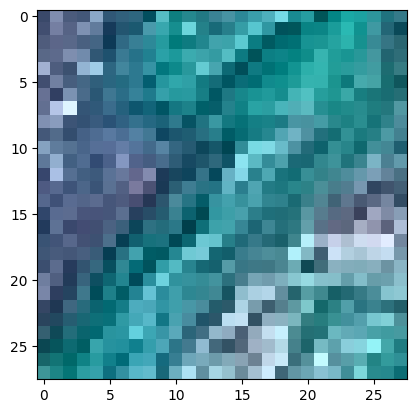

In [16]:
# Mixage des images MNIST avec le fond d'écran téléchargé

# Fonction qui extrait des patchs aléatoires de l'image téléchargée
def extract_random_patch(background, patch_size=(28, 28)):
    width, height = background.size
    x = random.randint(0, width - patch_size[0])
    y = random.randint(0, height - patch_size[1])
    return background.crop((x, y, x + patch_size[0], y + patch_size[1]))

# Affichage d'un crop exemple
print("----------- Crop exemple -----------\n")
plt.imshow(extract_random_patch(background_img, patch_size=(28, 28)))
plt.show()

# Fonction qui mélange les chiffres de MNIST avec les patchs aléatoires
def blend_mnist_digit_with_patch(mnist_digit, patch):
    # Les chiffres MNIST doivent être au format PIL Image
    mnist_digit = transforms.ToPILImage()(mnist_digit)

    # Création d'un masque qui récupère la forme du chiffre des images MNIST
    mnist_mask = mnist_digit.convert("L").point(lambda x: 255 if x > 0 else 0, mode='1')

    # Fusion du masque MNIST avec les patchs
    patch_with_digit = Image.composite(mnist_digit.convert("RGB"), patch, mnist_mask)

    return patch_with_digit

In [17]:
# Création d'une classe spécifique MNIST-M avec le fond d'écran personnalisé
class CustomMNISTMDataset(data.Dataset):
    def __init__(self, mnist_data, background, normalize, mean, std):
        self.mnist_data = mnist_data
        self.background = background
        if normalize:
          self.transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize(mean, std)
          ])
        else:
          self.transform = transforms.ToTensor()  # Ajout de la transformation pour convertir les images PIL en tensors

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        mnist_image, label = self.mnist_data[idx]
        patch = extract_random_patch(self.background)
        blended_image = blend_mnist_digit_with_patch(mnist_image, patch)
        blended_image_tensor = self.transform(blended_image)  # Convertit l'image PIL en tensor
        return blended_image_tensor, label

# Calcule la moyenne et la variance pour normaliser les tensors ensuite
def calculate_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Redimensionner le batch (batch, channels, height, width) en (batch, channels, height*width)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    # Calculer la moyenne et l'écart-type
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Création du dataset personnalisé MNIST-M AVANT normalisation pour calculer ses statistiques
mnistm_dataset = CustomMNISTMDataset(mnist_dataset_train, background_img, False, 0, 0)
mnistm_loader = DataLoader(mnistm_dataset, batch_size=batch_size, shuffle=False)

*La partie suivante peut mettre quelques secondes à tourner (surtout sur CPU), le calcul des statistiques est coûteux.*

Mean: tensor([0.6457, 0.6155, 0.7272])
Std: tensor([0.2713, 0.3035, 0.2272])

----------- Exemples d'images issues du dataset MNIST-M avant normalisation -----------



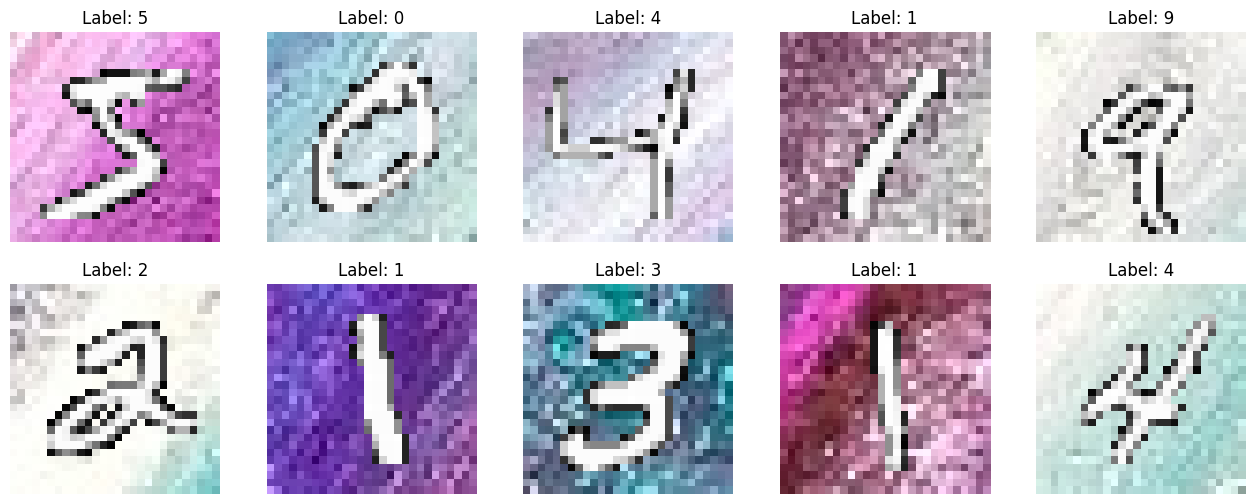

In [18]:
# Calcul de la moyenne et de l'écart-type de notre nouveau dataset MNIST-M
mean, std = calculate_mean_std(mnistm_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

# Affichage du dataset MNIST-M personnalisé avant normalisation
print("\n----------- Exemples d'images issues du dataset MNIST-M avant normalisation -----------\n")
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image_tensor, label = mnistm_loader.dataset[i]
    image_numpy = image_tensor.permute(1, 2, 0).numpy()  # Convertit le tensor en format numpy et réarrange les dimensions
    plt.imshow(image_numpy)
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.show()


----------- Exemples d'images issues du dataset MNIST-M après normalisation -----------



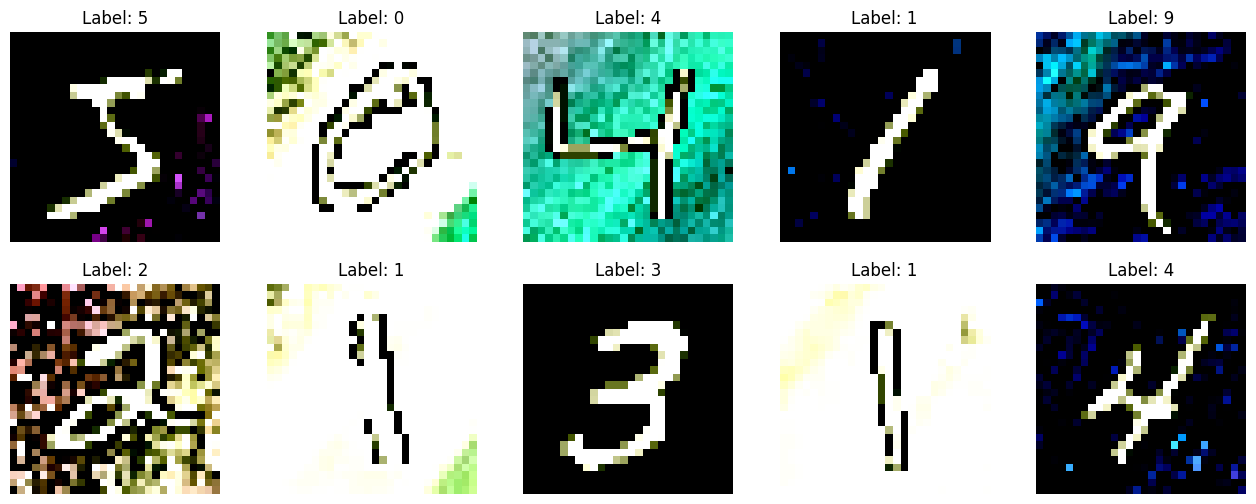

In [19]:
# Création du dataset MNIST-M personnalisé AVEC normalisation
mnistm_train_dataset_full = CustomMNISTMDataset(mnist_dataset_train, background_img, True, mean, std)
mnistm_test_dataset = CustomMNISTMDataset(mnist_dataset_test, background_img, True, mean, std)

indices = list(range(len(mnistm_train_dataset_full)))
validation_size = 5000
train_idx, valid_idx = indices[validation_size:], indices[:validation_size]
train_sampler = SubsetRandomSampler(train_idx)

# Création de DataLoaders pour le dataset MNIST-M personnalisé
mnistm_train_loader = DataLoader(
    mnistm_train_dataset_full,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

mnistm_test_loader = DataLoader(
    mnistm_test_dataset,
    batch_size=batch_size,
    num_workers=num_workers
)

# Affichage du dataset MNIST-M personnalisé APRES normalisation
print("\n----------- Exemples d'images issues du dataset MNIST-M après normalisation -----------\n")
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image_tensor, label = mnistm_train_loader.dataset[i]
    image_numpy = image_tensor.permute(1, 2, 0).numpy()  # Convertit le tensor en format numpy et réarrange les dimensions
    # Re-scale les données si elles sont en dehors de la plage [0, 1]
    if image_numpy.dtype == np.float32 or image_numpy.dtype == np.float64:
        image_numpy = np.clip(image_numpy, 0, 1)  # Assurez-vous que les valeurs sont entre 0 et 1
    # Ou convertit en entiers si les valeurs sont dans la plage [0, 255]
    elif image_numpy.max() > 1:
        image_numpy = (image_numpy * 255).astype(np.uint8)
    plt.imshow(image_numpy)
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.show()


Et voilà, nous avons nos deux datasets source et cible prêts à être entrainés avec un DANN !

# <a id="sec6">6. Test du DANN </a>

In [20]:
# Chargement des datasets MNIST (source) et MNIST-M (cible)

# Source : 0, Target :1
source_train_loader = mnist_train_loader
target_train_loader = mnistm_train_loader

source_test_loader = mnist_train_loader
target_test_loader = mnistm_train_loader

# Vérification que les dimensions sont compatibles avec notre NN
print("------ Dimensions des images du dataset MNIST ------")
for i, (images, labels) in enumerate(source_train_loader):
    print(f"Batch {i}: Image Shape = {images.shape}")
    if i == 3:  # Affiche les dimensions des images des 3 premiers lots
        break
# Vérifier la dimension d'une image spécifique
specific_image, _ = next(iter(source_train_loader))
print(f"Shape of a specific image: {specific_image[0].shape}")

# Si pas de GPU, cette partie peut bloquer et mettre beaucoup trop de temps (la commenter dans ce cas)

print("\n------ Dimensions des images du dataset MNIST-M ------")
for i, (images, labels) in enumerate(target_train_loader):
    print(f"Batch {i}: Image Shape = {images.shape}")
    if i == 3:  # Affiche les dimensions des images des 3 premiers lots
        break
specific_image, _ = next(iter(target_train_loader))
print(f"Shape of a specific image: {specific_image[0].shape}")

------ Dimensions des images du dataset MNIST ------
Batch 0: Image Shape = torch.Size([32, 1, 28, 28])
Batch 1: Image Shape = torch.Size([32, 1, 28, 28])
Batch 2: Image Shape = torch.Size([32, 1, 28, 28])
Batch 3: Image Shape = torch.Size([32, 1, 28, 28])
Shape of a specific image: torch.Size([1, 28, 28])

------ Dimensions des images du dataset MNIST-M ------
Batch 0: Image Shape = torch.Size([32, 3, 28, 28])
Batch 1: Image Shape = torch.Size([32, 3, 28, 28])
Batch 2: Image Shape = torch.Size([32, 3, 28, 28])
Batch 3: Image Shape = torch.Size([32, 3, 28, 28])
Shape of a specific image: torch.Size([3, 28, 28])


In [21]:
# Utilisation du GPU si disponible
if torch.cuda.is_available():
    encoder = Extractor().cuda()
    classifier = Classifier().cuda()
    discriminator = Discriminator().cuda()
else:
    print("No GPUs available, the running time will long ... very")
    encoder = Extractor().cpu()
    classifier = Classifier().cpu()
    discriminator = Discriminator().cpu()

##### Quelques fonction utiles

In [22]:
import torch.optim as optim
import itertools
from sklearn.manifold import TSNE

def set_model_mode(mode='train', models=None):
    for model in models:
        if mode == 'train':
            model.train()
        else:
            model.eval()

def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    # taux d'apprentissage ajusté durant la descente stochastique de gradient
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75 # formule donnée page 21 du papier [1]
    return optimizer

def save_model(encoder, classifier, discriminator, training_mode):
    print('Saving models ...')
    save_folder = 'trained_models'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    torch.save(encoder.state_dict(), 'trained_models/encoder_' + str(training_mode) + '.pt')
    torch.save(classifier.state_dict(), 'trained_models/classifier_' + str(training_mode) + '.pt')

    if training_mode == 'dann':
        torch.save(discriminator.state_dict(), 'trained_models/discriminator_' + str(training_mode) + '.pt')

    print('The model has been successfully saved!')

def plot_embedding(X, y, d, training_mode):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    y = list(itertools.chain.from_iterable(y))
    y = np.asarray(y)

    plt.figure(figsize=(10, 10))
    for i in range(len(d)):  # X.shape[0] : 1024
        # affiche chiffres colorés
        if d[i] == 0:
            colors = (0.0, 0.0, 1.0, 1.0)
        else:
            colors = (1.0, 0.0, 0.0, 1.0)
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=colors,
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])

    save_folder = 'saved_plot'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig_name = 'saved_plot/' + str(training_mode) + '.png'
    plt.savefig(fig_name)
    print('{} has been successfully saved!'.format(fig_name))

def visualize(encoder, training_mode):
    # Dessine 512 échantillons de test_data
    source_test_loader = mnist_test_loader
    target_test_loader = mnistm_test_loader

    # Récupère échantillons source_test
    source_label_list = []
    source_img_list = []
    for i, test_data in enumerate(source_test_loader):
        if i >= 16:  # avoir seulement 512 échantillons
            break
        img, label = test_data
        label = label.numpy()
        if torch.cuda.is_available():
            img = img.cuda()
        else:
            img = img.cpu()
        img = torch.cat((img, img, img), 1)  # MNIST channel 1 -> 3
        source_label_list.append(label)
        source_img_list.append(img)

    source_img_list = torch.stack(source_img_list)
    source_img_list = source_img_list.view(-1, 3, 28, 28)

    # Récupère échantillons target_test
    target_label_list = []
    target_img_list = []
    for i, test_data in enumerate(target_test_loader):
        if i >= 16:
            break
        img, label = test_data
        label = label.numpy()
        if torch.cuda.is_available():
            img = img.cuda()
        else:
            img = img.cpu()
        target_label_list.append(label)
        target_img_list.append(img)

    target_img_list = torch.stack(target_img_list)
    target_img_list = target_img_list.view(-1, 3, 28, 28)

    # Combine source_list + target_list
    combined_label_list = source_label_list
    combined_label_list.extend(target_label_list)
    combined_img_list = torch.cat((source_img_list, target_img_list), 0)

    source_domain_list = torch.zeros(512).type(torch.LongTensor)
    target_domain_list = torch.ones(512).type(torch.LongTensor)
    if torch.cuda.is_available():
        combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).cuda()
    else:
        combined_domain_list = torch.cat((source_domain_list, target_domain_list), 0).cpu()

    print("Extracting features to draw t-SNE plot...")
    combined_feature = encoder(combined_img_list)  # combined_feature : 1024,2352

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    dann_tsne = tsne.fit_transform(combined_feature.detach().cpu().numpy())

    print('Drawing t-SNE plot ...')
    plot_embedding(dann_tsne, combined_label_list, combined_domain_list, training_mode)

def process_data(data, expand_channels=False):
    images, labels = data
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
    else:
        images, labels = images.cpu(), labels.cpu()
    if expand_channels:
        images = images.repeat(1, 3, 1, 1)  # Répète les canaux pour convertir en images à 3 canaux
    return images, labels

def compute_output(encoder, classifier, images, alpha=None):
    features = encoder(images)
    if isinstance(classifier, Discriminator):
        outputs = classifier(features, alpha)  # Classificateur de domaine
    else:
        outputs = classifier(features)  # Classificateur de labels
    preds = outputs.data.max(1, keepdim=True)[1]
    return preds

def calculate_accuracy(correct, total):
    return 100. * correct / total

def print_accuracy(training_mode, accuracies):
    print(f"Test Results on {training_mode}:")
    for key, value in accuracies.items():
        print(f"{key} Accuracy: {value['correct']}/{value['total']} ({value['accuracy']:.2f}%)")

def tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode):
    if torch.cuda.is_available():
        encoder.cuda()
        classifier.cuda()
    else:
        encoder.cpu()
        classifier.cpu()
    set_model_mode('eval', [encoder, classifier])

    if training_mode == 'DANN':
        if torch.cuda.is_available():
            discriminator.cuda()
        else:
            discriminator.cpu()
        set_model_mode('eval', [discriminator])
        domain_correct = 0

    source_correct = 0
    target_correct = 0

    for batch_idx, (source_data, target_data) in enumerate(zip(source_test_loader, target_test_loader)):
        p = float(batch_idx) / len(source_test_loader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # formule donnée page 21 du papier [1]

        # Traite les données source et cible
        source_image, source_label = process_data(source_data, expand_channels=True)
        target_image, target_label = process_data(target_data)

        # Prédictions source et cible
        source_pred = compute_output(encoder, classifier, source_image, alpha=None)
        target_pred = compute_output(encoder, classifier, target_image, alpha=None)

        # Mise à jour
        source_correct += source_pred.eq(source_label.data.view_as(source_pred)).sum().item()
        target_correct += target_pred.eq(target_label.data.view_as(target_pred)).sum().item()

        if training_mode == 'DANN':
            # Traite les images combinées pour la classification de domaine
            combined_image = torch.cat((source_image, target_image), 0)
            if torch.cuda.is_available():
                domain_labels = torch.cat((torch.zeros(source_label.size(0), dtype=torch.long),
                                       torch.ones(target_label.size(0), dtype=torch.long)), 0).cuda()
            else:
                domain_labels = torch.cat((torch.zeros(source_label.size(0), dtype=torch.long),
                                           torch.ones(target_label.size(0), dtype=torch.long)), 0).cpu()

            # Predictions de domaine
            domain_pred = compute_output(encoder, discriminator, combined_image, alpha=alpha)
            domain_correct += domain_pred.eq(domain_labels.data.view_as(domain_pred)).sum().item()

    source_dataset_len = len(source_test_loader.dataset)
    target_dataset_len = len(target_test_loader.dataset)

    accuracies = {
        "Source": {
            "correct": source_correct,
            "total": source_dataset_len,
            "accuracy": calculate_accuracy(source_correct, source_dataset_len)
        },
        "Target": {
            "correct": target_correct,
            "total": target_dataset_len,
            "accuracy": calculate_accuracy(target_correct, target_dataset_len)
        }
    }

    if training_mode == 'DANN':
        accuracies["Domain"] = {
            "correct": domain_correct,
            "total": source_dataset_len + target_dataset_len,
            "accuracy": calculate_accuracy(domain_correct, source_dataset_len + target_dataset_len)
        }

    print_accuracy(training_mode, accuracies)

## 1. Source only (pas de DANN)

*Penser à exécuter la cellule cachée au dessus pour avoir les fonction utiles pour la suite.*

Le premier test que nous allons lancer avec nos données MNIST et MNIST-M est un réseau de neurones classique : un encodeur et un classificateur. Il sera entrainé sur le dataset MNIST (domaine source) uniquement, sans tenir compte du domaine cible (aucune branche de régresseur de domaine incluse dans le réseau). Nous allons ensuite vérifier son efficacité sur les nouvelles données MNIST-M (domaine cible).

In [23]:
def source_only(encoder, classifier, source_train_loader, target_train_loader):
    print("Training with only the source dataset")

    if torch.cuda.is_available():
        classifier_criterion = nn.CrossEntropyLoss().cuda()
    else:
        classifier_criterion = nn.CrossEntropyLoss().cpu()
    optimizer = optim.SGD(
        list(encoder.parameters()) +
        list(classifier.parameters()),
        lr=0.01, momentum=0.9)

    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        set_model_mode('train', [encoder, classifier])

        start_steps = epoch * len(source_train_loader)
        total_steps = epochs * len(target_train_loader)

        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):
            source_image, source_label = source_data
            p = float(batch_idx + start_steps) / total_steps

            source_image = torch.cat((source_image, source_image, source_image), 1)  # MNIST conversion 3 canaux
            if torch.cuda.is_available():
                source_image, source_label = source_image.cuda(), source_label.cuda()  # 32
            else:
                source_image, source_label = source_image.cpu(), source_label.cpu()

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            source_feature = encoder(source_image)

            # Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            class_loss.backward()
            optimizer.step()
            if (batch_idx + 1) % 100 == 0:
                total_processed = batch_idx * len(source_image)
                total_dataset = len(source_train_loader.dataset)
                percentage_completed = 100. * batch_idx / len(source_train_loader)
                print(f'[{total_processed}/{total_dataset} ({percentage_completed:.0f}%)]\tClassification Loss: {class_loss.item():.4f}')

        tester(encoder, classifier, None, source_test_loader, target_test_loader, training_mode='Source_only')

    save_model(encoder, classifier, None, 'Source-only')
    visualize(encoder, 'Source-only')

Vous êtes maintenant prêts à lancer le réseau de neurones !

*Remarques* : la cellule suivante devrait mettre environ 5 minutes en utilisant un GPU (~ 8 minutes avec CPU Google Colab). C'est donc le moment parfait pour aller prendre un café avant d'attaquer la partie visualisation et interprétation qui suit.

Training with only the source dataset
Epoch: 0
[3168/60000 (6%)]	Classification Loss: 0.3341
[6368/60000 (12%)]	Classification Loss: 0.3560
[9568/60000 (17%)]	Classification Loss: 0.2489
[12768/60000 (23%)]	Classification Loss: 0.0243
[15968/60000 (29%)]	Classification Loss: 0.2469
[19168/60000 (35%)]	Classification Loss: 0.0107
[22368/60000 (41%)]	Classification Loss: 0.0231
[25568/60000 (46%)]	Classification Loss: 0.0572
[28768/60000 (52%)]	Classification Loss: 0.0534
[31968/60000 (58%)]	Classification Loss: 0.0041
[35168/60000 (64%)]	Classification Loss: 0.0057
[38368/60000 (70%)]	Classification Loss: 0.0045
[41568/60000 (76%)]	Classification Loss: 0.0407
[44768/60000 (81%)]	Classification Loss: 0.0230
[47968/60000 (87%)]	Classification Loss: 0.0205
[51168/60000 (93%)]	Classification Loss: 0.0244
[54368/60000 (99%)]	Classification Loss: 0.0149
Test Results on Source_only:
Source Accuracy: 54294/60000 (90.49%)
Target Accuracy: 32094/60000 (53.49%)
Epoch: 1
[3168/60000 (6%)]	Classific

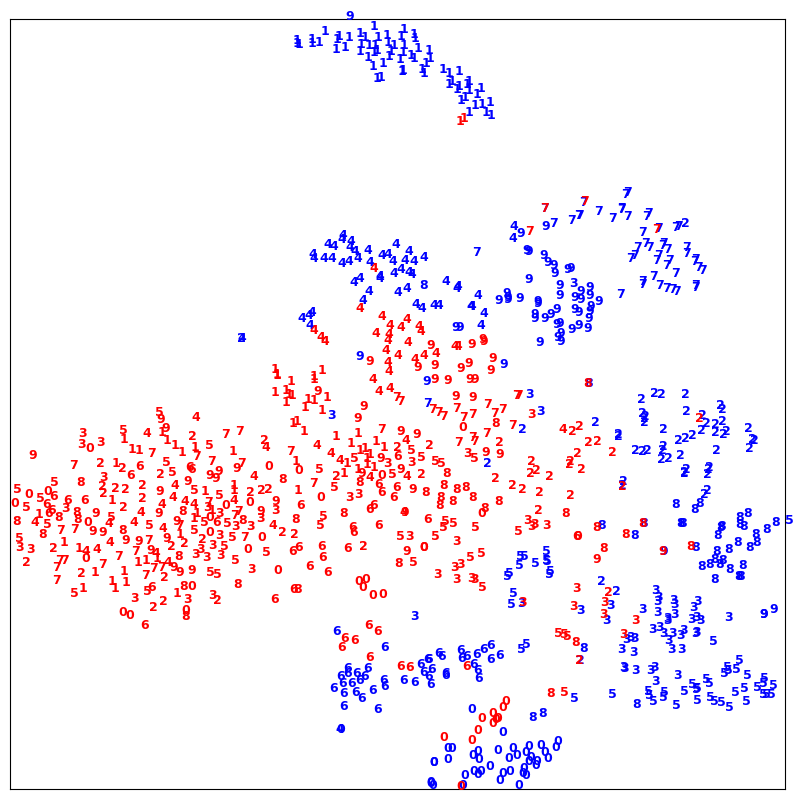

In [24]:
source_only(encoder, classifier, source_train_loader, target_train_loader)

Pour visualiser, nous avons choisi le **diagramme t-SNE (t-distributed Stochastic Neighbor Embedding)**. Il s'agit d'une méthode de réduction de dimensionnalité utilisée pour visualiser des données de grande dimension. Elle fonctionne en préservant la structure locale des données, assurant que les points proches dans l'espace d'origine restent proches dans l'espace réduit.

L'exemple que vous avez fait tourner ne comportait que 3 époques pour des raisons évidentes de temps de calcul. Vous trouverez juste après le résultat pour 10 époques (~ 16 minutes de calcul avec GPU), avec l'image *background.jpg*.

Votre résultat peut être légèrement différent du fait du nombre d'époques mais voilà une idée (en mieux !) de ce que vous devriez obtenir :


 <details class="alert alert-success">
    <summary markdown="span"><b>Voir la TSNE - source only - 10 époques (cliquer ici)</b></summary>

 ![TSNE source only - 10 epochs](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/plot_source_only_10_epochs.png?raw=1)
 ![résultats source only - 10 epochs](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/res_source_only_10_epochs.png?raw=1)

Légende :
- chiffres bleus : domaine source (MNIST);
- chiffres rouges : domaine cible (MNIST-M).

</details>



<div class="alert alert-warning">
<b>Exercice 5</b> : Quelle est votre première interprétation en voyant cela ?
</div>

 <details class="alert alert-success">
    <summary markdown="span"><b>Interprétation (cliquer ici)</b></summary>

1. Si l'on regarde d'abord les <b>chiffres bleus</b> : ils correspondent au test du NN avec le dataset source MNIST, autrement dit celui pour lequel il a été entraîné. On remarque la formation de paquets bien nets et bien distincts entre les classes de chiffres, avec quelques petites erreurs mais tout de même une très bonne précision (~92%). Cela signifie que le NN a bien été entrainé, jusque là tout est normal !
2. Si l'on regarde maintenant les <b>chiffres rouges</b> : ça devient plus compliqué ... ils correspondent au test du NN avec le dataset cible MNIST-M qui présente un décalage dans sa distribution comparé aux données d'entrainement MNIST. On voit que la classification est très limitée, tous les chiffres sont regroupés en un gros paquet désordonné. L'algorithme classifie en prenant compte du domaine (excatement ce qu'on ne veut pas). Notons qu'il y a quand même quelques réussites mais la précision est largement réduite (~56%).

</details>

La solution pour répondre à ce problème est évidemment le DANN ! Voyons s'il y a des améliorations.


## 2. DANN

A la différence du code du dessus, on ajoute un discriminateur (ou régresseur de domaine) pour la classification de domaine associé à une GRL pour en faire un DANN.

In [25]:
def dann(encoder, classifier, discriminator, source_train_loader, target_train_loader):
    print("Training with the DANN adaptation method")

    if torch.cuda.is_available():
      classifier_criterion = nn.CrossEntropyLoss().cuda()
      discriminator_criterion = nn.CrossEntropyLoss().cuda()
    else:
      classifier_criterion = nn.CrossEntropyLoss().cpu()
      discriminator_criterion = nn.CrossEntropyLoss().cpu()

    optimizer = optim.SGD(
        list(encoder.parameters()) +
        list(classifier.parameters()) +
        list(discriminator.parameters()),
        lr=0.01,
        momentum=0.9)

    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        set_model_mode('train', [encoder, classifier, discriminator])

        start_steps = epoch * len(source_train_loader)
        total_steps = epochs * len(target_train_loader)

        for batch_idx, (source_data, target_data) in enumerate(zip(source_train_loader, target_train_loader)):

            source_image, source_label = source_data
            target_image, target_label = target_data

            p = float(batch_idx + start_steps) / total_steps
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            source_image = torch.cat((source_image, source_image, source_image), 1)

            if torch.cuda.is_available():
              source_image, source_label = source_image.cuda(), source_label.cuda()
              target_image, target_label = target_image.cuda(), target_label.cuda()
            else:
              source_image, source_label = source_image.cpu(), source_label.cpu()
              target_image, target_label = target_image.cpu(), target_label.cpu()
            combined_image = torch.cat((source_image, target_image), 0)

            optimizer = optimizer_scheduler(optimizer=optimizer, p=p)
            optimizer.zero_grad()

            combined_feature = encoder(combined_image)
            source_feature = encoder(source_image)

            # 1.Classification loss
            class_pred = classifier(source_feature)
            class_loss = classifier_criterion(class_pred, source_label)

            # 2. Domain loss
            domain_pred = discriminator(combined_feature, alpha)

            domain_source_labels = torch.zeros(source_label.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(target_label.shape[0]).type(torch.LongTensor)
            if torch.cuda.is_available():
              domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cuda()
            else:
              domain_combined_label = torch.cat((domain_source_labels, domain_target_labels), 0).cpu()
            domain_loss = discriminator_criterion(domain_pred, domain_combined_label)

            total_loss = class_loss + domain_loss
            total_loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print('[{}/{} ({:.0f}%)]\tTotal Loss: {:.4f}\tClassification Loss: {:.4f}\tDomain Loss: {:.4f}'.format(
                    batch_idx * len(target_image), len(target_train_loader.dataset), 100. * batch_idx / len(target_train_loader), total_loss.item(), class_loss.item(), domain_loss.item()))

        tester(encoder, classifier, discriminator, source_test_loader, target_test_loader, training_mode='DANN')

    save_model(encoder, classifier, discriminator, 'DANN')
    visualize(encoder, 'DANN')

De même que précédemment, la cellule suivante met environ 5 minutes avec GPU à tourner (~ 15 minutes avec CPU Google Colab) --> un autre café ?.

*Remarque :* pour des résultats plus marqués, il est possible d'augmenter le nombre d'époques, mais cela prendra forcément plus de temps. Voir résultats donnés juste après.

Training with the DANN adaptation method
Epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[3168/60000 (6%)]	Total Loss: 0.0956	Classification Loss: 0.0533	Domain Loss: 0.0423
[6368/60000 (12%)]	Total Loss: 0.0134	Classification Loss: 0.0078	Domain Loss: 0.0056
[9568/60000 (17%)]	Total Loss: 0.3404	Classification Loss: 0.0218	Domain Loss: 0.3185
[12768/60000 (23%)]	Total Loss: 0.3873	Classification Loss: 0.2716	Domain Loss: 0.1156
[15968/60000 (29%)]	Total Loss: 0.1971	Classification Loss: 0.0090	Domain Loss: 0.1880
[19168/60000 (35%)]	Total Loss: 0.1278	Classification Loss: 0.0081	Domain Loss: 0.1197
[22368/60000 (41%)]	Total Loss: 0.0812	Classification Loss: 0.0448	Domain Loss: 0.0365
[25568/60000 (46%)]	Total Loss: 0.1511	Classification Loss: 0.0036	Domain Loss: 0.1475
[28768/60000 (52%)]	Total Loss: 0.4025	Classification Loss: 0.2759	Domain Loss: 0.1266
[31968/60000 (58%)]	Total Loss: 0.2052	Classification Loss: 0.0748	Domain Loss: 0.1304
[35168/60000 (64%)]	Total Loss: 0.1200	Classification Loss: 0.0114	Domain Loss: 0.1086
[38368/60000 (70%)]	Total Loss: 0.1117	Classifi

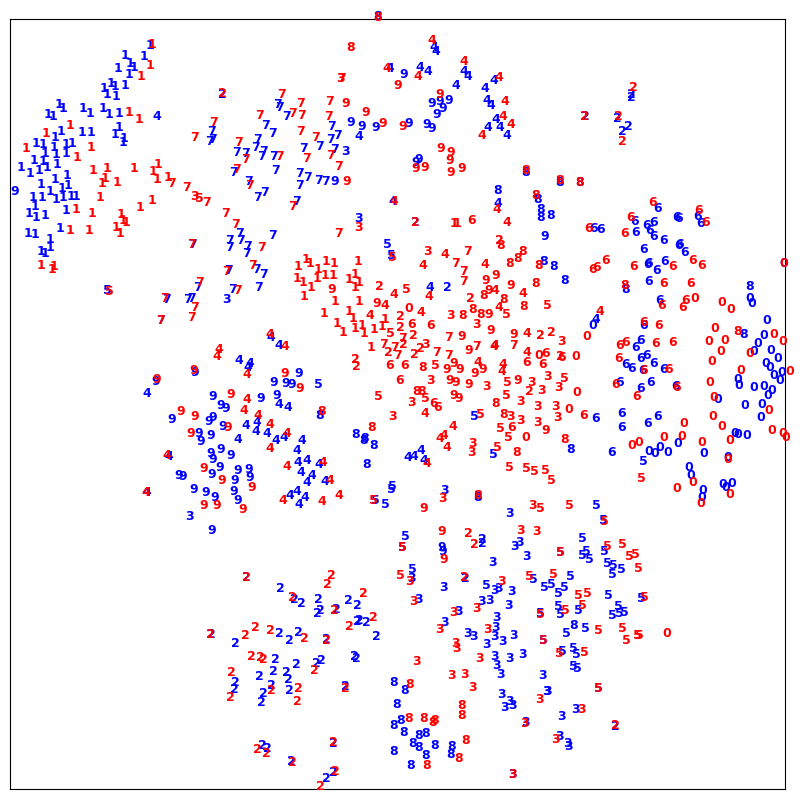

In [26]:
dann(encoder, classifier, discriminator, source_train_loader, target_train_loader)

 Il vous est une nouvelle fois proposé une visualisation TSNE avec 10 époques (~ 17 minutes de calcul avec GPU) pour l'image *background.jpg* :

 <details class="alert alert-success">
    <summary markdown="span"><b>Voir la TSNE - DANN - 10 époques (cliquer ici)</b></summary>

 ![TSNE DANN - 10 epochs](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/plot_dann_10_epochs.png?raw=1)
 ![résultats DANN - 10 epochs](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/res_dann_10_epochs.png?raw=1)

Légende :
- chiffres bleus : domaine source (MNIST);
- chiffres rouges : domaine cible (MNIST-M).

</details>

<div class="alert alert-warning">
<b>Exercice 6</b> : Comparez et interprétez ces nouveaux résultats.
</div>

 <details class="alert alert-success">
    <summary markdown="span"><b>Interprétation (cliquer ici)</b></summary>

1. Si l'on regarde d'abord les <b>chiffres bleus</b> : encore une fois tout est normal ! Les chiffres sont agglomérés en fonction de leur classe et sont bien prédits avec une précision de 91% (le NN fait bien son travail), bien qu'on note une très légère baisse comparé à l'exemple *source-only*.
2. Si l'on regarde maintenant les <b>chiffres rouges </b>: on remarque une nette différence avec le cas précédent ! Déjà, la précision a largement été améliorée avec un score de presque 87%, ce qui est loin des 57% de tout à l'heure. L'efficacité du DANN sur ce genre de problème est alors incontestable. On voit en plus que les chiffres rouges (MNIST-M) sont répartis et éparpillés de manière plus homogène au sein des bleus (MNIST). C'est de là que vient le score plus élevé : l'algorithme ne sait plus faire la différence entre le domaine source et le domaine cible (score de moins de 57%), il se trompe près d'une fois sur deux. Finalement, cette méthode permet clairement de faire des prédictions selon la distribution des caractéristiques et non pas du domaine.

</details>

Au final, voici les résultats résumés au sein d'un tableau, pour l'image 1 (*background.jpg*) et l'image 2 (*background2.jpg*), avec epochs=10, batch_size=32 et num_workers=4.

![Tableau résultats DANN](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/table_res_DANN.png?raw=1)

# <a id="sec7">7. Autres résultats</a>

### Données synthétiques et réelles

Pour compléter l'expérience ci-dessus, il est possible de la comparer avec les résultats de l'article [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818) [1].
Les conditions étaient les suivantes :
- batch-size = 128 ;
- pas d'information sur le nombre d'époques (une centaine ? plus ? beaucoup ...) ;
- pour plus de détails, cf pages 20-23 de [1].

![Paires à tester](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/pairs_to_test.png?raw=1)

1. *MNIST -> MNIST-M* : pour obtenir le domaine cible (MNIST-M), mélange des chiffres de l'ensemble d'origine MNIST sur des patchs extraits de manière aléatoire à partir de photos couleur du BSDS500 (Arbelaez et al., 2011) [9] ;
2. *Nombres synthétiques -> SVHN* (*Street-View House Number*, Netzer et al., 2011) [10] : scénario courant d'entraînement sur des données synthétiques et de test sur des données réelles.

![Résultats paires à tester](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/res_pairs_to_test.png?raw=1)

**Interprétation :** Encore une fois, on voit que l’adaptation rend les deux distributions de caractéristiques beaucoup plus proches.

![Table paires à tester](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/res_pairs_to_test_table.png?raw=1)

**Interprétation :** La première ligne correspond à la limite inférieure de performance (c'est-à-dire, si aucune adaptation n'est réalisée). La dernière ligne correspond à l'entraînement sur les données de domaine cible si l'on avait les labels connus (limite supérieure). Pour les deux cas, l'approche DANN surpasse considérablement la méthode SA (*subspace alignment*) de Fernando et al. [11] et couvre même une grande partie de l'écart.

### Autres datasets

<div class="alert alert-info">
Le <b> dataset OFFICE </b> (Saenko et al., 2010) [12] est une collection d'images de produits de bureau utilisée dans la recherche sur l'adaptation de domaine, qui comprend des images provenant de trois sources distinctes : <b> Amazon, une webcam et un appareil photo DSLR </b>. Ces images représentent les mêmes catégories d'objets mais diffèrent par leur qualité et leur contexte en raison des différentes sources. Le dataset est conçu pour développer des modèles de machine learning qui peuvent s'adapter et généraliser d'un domaine source vers un domaine cible sans données étiquetées supplémentaires pour ce dernier (adaptation de domaine non-supervisée).
</div>

![Résultats OFFICE dataset](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/res_office.png?raw=1)

# <a id="sec8">8. Ouverture à d'autres applications </a>

Jusqu'ici, nous avons implémenté un exemple concret de DANN dans le contexte de la **classification d'images**.


### Analyse de sentiments

Une autre application reconnue du DANN est **l'analyse de sentiments**. Le DANN améliore par exemple le state-of-the-art *marginalized Stacked Autoencoders* (mSDA) de Chen et al. (2012) [9] sur le benchmark commun des avis Amazon.

### Ré-identification de personnes

Le DANN a également été validé dans le cadre d'une application de **ré-identification de personnes** (Gong et al., 2014) [13], où le but est de reconnaître ou de suivre des individus à travers différentes caméras ou dans des images différentes. Elle est utilisée dans les systèmes de surveillance et de sécurité pour suivre les mouvements des personnes dans différents emplacements ou à différents moments. Des points de vue disjoints, des poses différentes, mais aussi une luminosité et une qualité différentes rendent la tâche extrêmement compliquée, même pour les humains.
La ré-identification de personnes entre bien dans le cadre de l'adaptation de domaine puisque chaque réseau de caméras est en fait un domaine différent.

![Ré-identification de personnes](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/re_id.png?raw=1)

Les méthodes de deep learning ne sont pas forcément les meilleures dans ce domaine (sûrement à cause des datasets d'entrainement de taille limitée) mais le DANN représente une bonne voie d'amélioration en ré-identification.

![Résultats ré-identification de personnes](https://github.com/anonymusSDD/DANN_notebook/blob/main/img/res_re_id.png?raw=1)

Cette application sort un peu du cadre de notre étude et se présente comme une ouverture à l'étendue du champ d'application du DANN. Pour plus d'informations, se référer aux pages 26-30 de l'article [1].

### Applications plus récentes

Depuis la publicatoin de l'article [1] en 2015, de nouvelles applications on été testées et approuvées.
Par exemple :
- la reconnaissance automatique de la parole avec différents accents (*Domain Adversarial Training for Accented Speech Recognition, Sun et al., 2017*) ;
- l'application en imagerie médicale pour la détection de mitoses dans les images de cancer du sein ou pour la segmentation des lésions cérébrales (*Domain-Adversarial Neural Networks to Address the Appearance Variability of Histopathology Images, Lafarge et al., 2017* et *Unsupervised Domain Adaptation in Brain Lesion Segmentation with Adversarial Networks, Kamnitsas et al., 2016*) ;
- l'étude de l'influence des descriptions de produits dans le commerce électronique sur les comportements d'achat des consommateurs (*Predicting Sales from the Language of Product Descriptions, Pryzant et al., 2017*) ;
- l'identification des transitions de phase dans divers modèles quantiques (*Adversarial Domain Adaptation for Identifying Phase Transitions, Huembeli et al., 2017*) ;
- l'amélioration de la saisie en robotique (*Using Simulation and Domain Adaptation to Improve Efficiency of Deep Robotic Grasping, Bousmalis et al., 2017*) ;
- etc.

Les champs d'application du DANN sont extrêmement vastes.

# <a id="sec9">9. Conclusion</a>

<div class="alert alert-success">

* <b>L'objectif</b> de ce cours était de présenter une nouvelle approche d’apprentissage pour l'<b>adaptation de domaine (DA)</b> en favorisant l'émergence de représentations qui sont :

        1. discriminantes pour la tâche d'apprentissage principale sur le domaine source,
        2. non-discriminantes pour la détection du domaine.
        
* <b>Les moyens</b> : proposer une <b>approche simple et générique</b> d’apprentissage d'adaptation de domaine, qui peut être implémentée avec peu d’effort en utilisant n’importe quel paquet de deep learning, et qui offre une interprétation théorique basée sur la $H$-divergence.
* <b>La méthode</b> : utiliser un <b>réseau de neurones profond</b> avec une <b>couche spéciale de renversement du gradient (GRL)</b>, qui permet d’optimiser les caractéristiques de manière à minimiser la perte de prédiction des labels sur le domaine source et à maximiser la perte de classification du domaine sur les deux domaines.
* <b>Résultats</b> : le DANN nous a permis d'atteindre des performances de pointe sur plusieurs tâches d’adaptation de domaine, telles que <b>la classification d’images, l’analyse de sentiments et la ré-identification de personnes</b>, en utilisant différentes architectures de réseaux de neurones.
</div>

# <a id="sec10">10. Références</a>
Le contenu de ce notebook repose en grande partie sur la lecture de [1]. D'autres articles et supports sont venus le compléter.

1. Ganin Y., Ustinova E., Ajakan H., Germain P., Larochelle H., Laviolette F., Marchand M., and Lempitsky V. [Domain-Adversarial Training of Neural Networks](https://arxiv.org/abs/1505.07818). In *Journal of Machine Learning Research*, pages 1-35, 2015.
2. Farahani A., Voghoei S., Rasheed K., and R. Arabnia H. [A Brief Review Of Domain Adaptation](https://arxiv.org/pdf/2010.03978v1.pdf), 2020.
3. Github [NaJaeMin92/pytorch-DANN] (https://github.com/NaJaeMin92/pytorch-DANN/tree/master)
3. Github [vcoyette/DANN](https://github.com/vcoyette/DANN/tree/master)
4. Vidéo YouTube [Introduction aux Domain Adversarial Neural Networks (DANN)](https://www.youtube.com/watch?v=_Y1GAt3UxO4) par Philippe Giguère, Université Laval, 2023.
5. Vidéo YouTube [[ML 2021 (English version)] Lecture 27: Domain Adaptation](https://www.youtube.com/watch?v=8AKqH6V9kjE) par Hung-yi Lee, 2021.
6. Shai Ben-David, John Blitzer, Koby Crammer, and Fernando Pereira. Analysis of representations for domain adaptation. In *NIPS*, pages 137- 144, 2006.
7. Shai Ben-David, John Blitzer, Koby Crammer, Alex Kulesza, Fernando Pereira, and Jennifer Wortman Vaughan. A theory of learning from different domains. *Machine Learning*, 79(1-2):151-175, 2010.
8. Minmin Chen, Zhixiang Eddie Xu, Kilian Q. Weinberger, and Fei Sha. Marginalized denoising autoencoders for domain adaptation. In *ICML*, pages 767-774, 2012.
7. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. *Proceedings of the IEEE*, 86(11):2278-2324, November 1998.
8. Erheng Zhong, Wei Fan, Qiang Yang, Olivier Verscheure, and Jiangtao Ren. Cross validation framework to choose amongst models and datasets for transfer learning. In *Machine Learning and Knowledge Discovery in Databases*, pages 547-562. Springer, 2010.
9. Pablo Arbelaez, Michael Maire, Charless Fowlkes, and Jitendra Malik. Contour detection and hierarchical image segmentation. *IEEE Transaction Pattern Analysis and Machine Intelligence*, 33, 2011.
10. Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, and Andrew Y. Ng. Reading digits in natural images with unsupervised feature learning. In *NIPS Workshop on Deep Learning and Unsupervised Feature Learning*, 2011.
11. Basura Fernando, Amaury Habrard, Marc Sebban, and Tinne Tuytelaars. Unsupervised visual domain adaptation using subspace alignment. In *ICCV*, 2013.
12. Kate Saenko, Brian Kulis, Mario Fritz, and Trevor Darrell. Adapting visual category models to new domains. In *ECCV*, pages 213-226, 2010.
13. Shaogang Gong, Marco Cristani, Shuicheng Yan, and Chen Change Loy. Person re-identiffication. *Springer*, 2014.

# --- FIN ---